In [1]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("data_imu_oke.csv")

# Sliding window function
def sliding_window(df, window_size):
    segments = []
    for start in range(0, len(df), window_size):
        end = start + window_size
        if end <= len(df):
            window = df.iloc[start:end]
            segments.append(window)
    return segments

segments = sliding_window(df, window_size=32)  # Contoh: 2 detik x 16 Hz


In [2]:
from scipy.fft import fft

# Ekstraksi fitur dari tiap segmen
def extract_features(segment):
    features = {}
    for col in ['ax', 'ay', 'az', 'gx', 'gy', 'gz']:
        data = segment[col].values
        fft_data = np.abs(fft(data))
        features[f'{col}_mean'] = np.mean(data)
        features[f'{col}_std'] = np.std(data)
        features[f'{col}_energy'] = np.sum(data**2)
        features[f'{col}_fft_max'] = np.max(fft_data)
        features[f'{col}_fft_mean'] = np.mean(fft_data)
    features['label'] = segment['label'].iloc[0]
    return features

# Buat dataframe fitur
features_df = pd.DataFrame([extract_features(seg) for seg in segments])


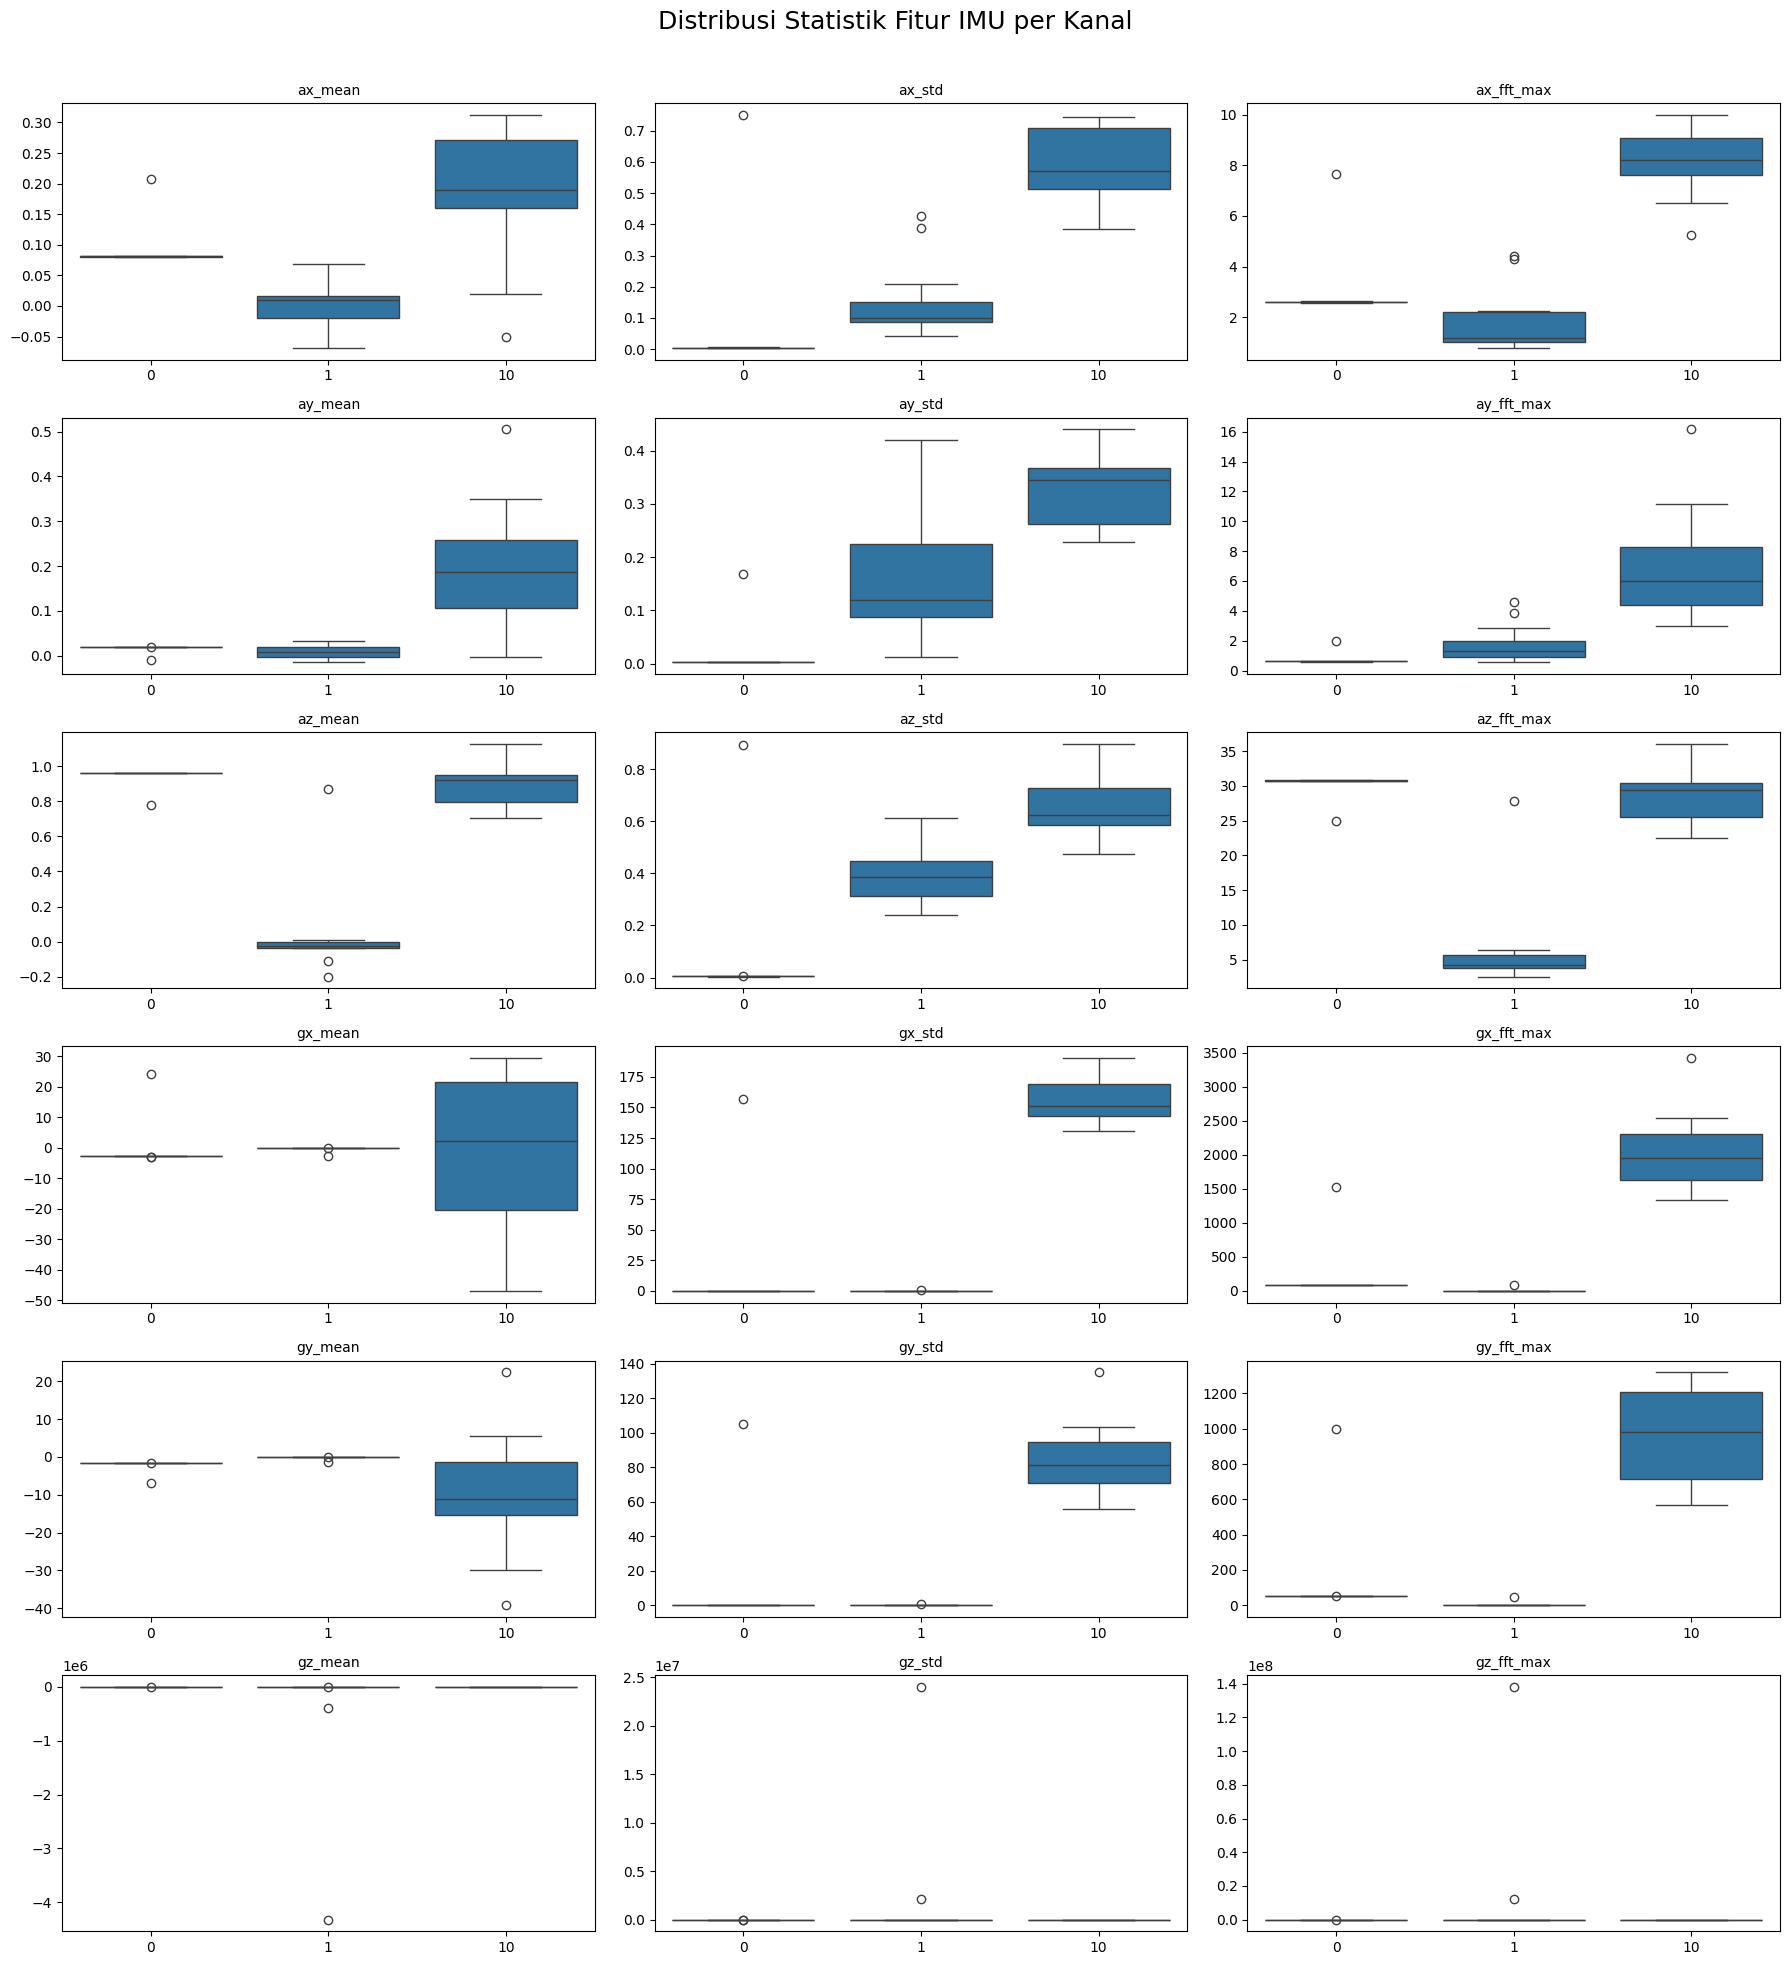

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pilihan fitur yang akan divisualisasikan
feature_groups = [
    ['ax_mean', 'ax_std', 'ax_fft_max'],
    ['ay_mean', 'ay_std', 'ay_fft_max'],
    ['az_mean', 'az_std', 'az_fft_max'],
    ['gx_mean', 'gx_std', 'gx_fft_max'],
    ['gy_mean', 'gy_std', 'gy_fft_max'],
    ['gz_mean', 'gz_std', 'gz_fft_max']
]

fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(18, 20))
fig.suptitle('Distribusi Statistik Fitur IMU per Kanal', fontsize=18)

for i, group in enumerate(feature_groups):
    for j, feat in enumerate(group):
        sns.boxplot(data=features_df, x='label', y=feat, ax=axs[i, j])
        axs[i, j].set_title(f'{feat}', fontsize=10)
        axs[i, j].set_xlabel('')
        axs[i, j].set_ylabel('')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


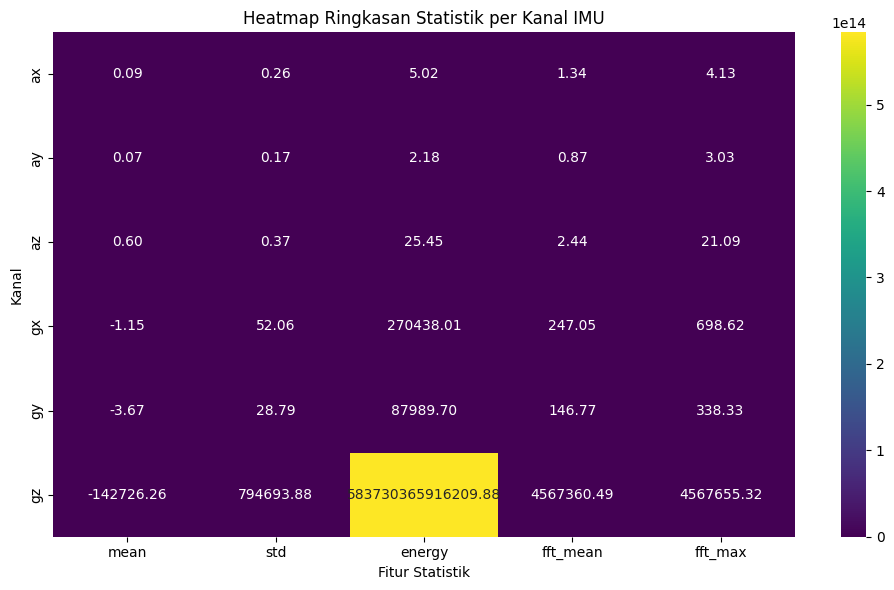

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ringkasan statistik (mean, std, energy, fft_mean, fft_max)
stats_matrix = pd.DataFrame({
    'mean': [features_df[f'{s}_mean'].mean() for s in ['ax','ay','az','gx','gy','gz']],
    'std': [features_df[f'{s}_std'].mean() for s in ['ax','ay','az','gx','gy','gz']],
    'energy': [features_df[f'{s}_energy'].mean() for s in ['ax','ay','az','gx','gy','gz']],
    'fft_mean': [features_df[f'{s}_fft_mean'].mean() for s in ['ax','ay','az','gx','gy','gz']],
    'fft_max': [features_df[f'{s}_fft_max'].mean() for s in ['ax','ay','az','gx','gy','gz']],
}, index=['ax','ay','az','gx','gy','gz'])

plt.figure(figsize=(10,6))
sns.heatmap(stats_matrix, annot=True, fmt=".2f", cmap="viridis")
plt.title("Heatmap Ringkasan Statistik per Kanal IMU")
plt.ylabel("Kanal")
plt.xlabel("Fitur Statistik")
plt.tight_layout()
plt.show()


In [5]:
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff=5, fs=50, order=4):
    b, a = butter(order, cutoff / (0.5 * fs), btype='low')
    return filtfilt(b, a, data)


In [6]:
import numpy as np

def segment_signal(data, window_size, overlap):
    step = window_size - overlap
    segments = []
    for start in range(0, len(data) - window_size + 1, step):
        segment = data[start:start + window_size]
        segments.append(segment)
    return np.array(segments)


In [7]:
import pandas as pd
import numpy as np

# Fungsi Normalisasi Z-score
def normalize_imu(dataframe, cols):
    return (dataframe[cols] - dataframe[cols].mean()) / dataframe[cols].std()

# Fungsi Segmentasi Sliding Window
def segment_signal(data, window_size, overlap):
    step = window_size - overlap
    segments = []
    for start in range(0, len(data) - window_size + 1, step):
        segment = data[start:start + window_size]
        segments.append(segment)
    return np.array(segments)

# Fungsi Ekstraksi Fitur
def extract_features(window, kanal_list):
    features = {}
    for i, kanal in enumerate(kanal_list):
        signal = window[:, i]
        features[f'{kanal}_mean'] = np.mean(signal)
        features[f'{kanal}_std'] = np.std(signal)
        features[f'{kanal}_energy'] = np.sum(signal ** 2)
        fft_vals = np.abs(np.fft.fft(signal))
        features[f'{kanal}_fft_mean'] = np.mean(fft_vals)
        features[f'{kanal}_fft_max'] = np.max(fft_vals)
    return features

# Pipeline Utama
def imu_pipeline(df, window_size=100, overlap=50):
    kanal_imu = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
    
    # Normalisasi
    df_norm = normalize_imu(df, kanal_imu)
    data_array = df_norm[kanal_imu].values

    # Segmentasi
    segmented_windows = segment_signal(data_array, window_size, overlap)

    # Ekstraksi Fitur per Window
    features = [extract_features(win, kanal_imu) for win in segmented_windows]
    features_df = pd.DataFrame(features)

    return features_df


In [8]:
raw_df = pd.read_csv("data_imu_oke.csv")  # Ganti dengan sumbermu
features_df = imu_pipeline(raw_df, window_size=128, overlap=64)
features_df.head()


,ax_mean,ax_std,ax_energy,ax_fft_mean,ax_fft_max,ay_mean,ay_std,ay_energy,ay_fft_mean,ay_fft_max,...,gy_mean,gy_std,gy_energy,gy_fft_mean,gy_fft_max,gz_mean,gz_std,gz_energy,gz_fft_mean,gz_fft_max
0,-0.228137,0.335729,21.089299,3.617195,29.201542,-0.321572,0.763758,87.902188,7.878119,41.161265,...,0.070073,0.003792,0.630358,0.106917,8.969407,-0.222678,2.881874e+00,1069.412332,32.699750,32.732799
1,-0.246684,0.629336,58.485302,6.573973,31.575541,-0.302111,0.950419,127.304675,9.736246,38.670187,...,0.069403,0.002275,0.617216,0.091953,8.883628,0.009946,2.603360e-01,8.687838,2.943783,2.956940
2,-0.293735,0.752335,83.492958,7.745980,37.598080,-0.234538,1.144003,174.560067,11.443531,30.020811,...,0.069932,0.001812,0.626409,0.087250,8.951346,0.009946,2.603360e-01,8.687838,2.943783,2.956940
3,-0.250563,0.548397,46.530760,5.804899,32.072100,-0.201739,0.909552,111.101907,8.979351,25.822581,...,0.070353,0.000978,0.633670,0.079860,9.005224,0.033047,5.906190e-08,0.139788,0.033047,4.229991
4,-0.175708,0.237534,11.173824,2.535769,22.490599,-0.229409,0.301247,18.352365,3.121183,29.364303,...,0.063612,0.012278,0.537247,0.128969,8.142348,0.033047,3.216300e-08,0.139788,0.033047,4.229988


In [9]:
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder

def feature_selection_pipeline(features_df, label_series, top_n=10):
    selected_features = {}
    feature_names = features_df.columns.tolist()
    
    # Encode label jika belum numerik
    label_encoded = LabelEncoder().fit_transform(label_series)
    
    # Korelasi Pearson
    pearson_scores = features_df.corrwith(label_series, method='pearson').abs().fillna(0)
    
    # ANOVA F-score
    f_scores, _ = f_classif(features_df, label_encoded)

    # Gabungkan dan rangking
    ranking = pd.DataFrame({
        'Feature': feature_names,
        'Pearson': pearson_scores.values,
        'ANOVA_F': f_scores
    }).sort_values(by='ANOVA_F', ascending=False).head(top_n)

    selected_features['ranking_df'] = ranking
    selected_features['heatmap_df'] = features_df[ranking['Feature']]
    selected_features['latex_table'] = ranking.to_latex(index=False, float_format="%.3f")

    return selected_features


In [10]:
import plotly.express as px

def visualize_feature_selection(selected_features):
    heatmap_df = selected_features['heatmap_df']
    
    # Korelasi antar fitur terpilih
    corr_matrix = heatmap_df.corr()

    fig_corr = px.imshow(corr_matrix,
                         color_continuous_scale='RdBu',
                         title='Heatmap Korelasi Fitur Terpilih')
    fig_corr.update_layout(width=800, height=600)
    fig_corr.show()

    # Bar plot ranking ANOVA
    fig_rank = px.bar(selected_features['ranking_df'],
                      x='Feature', y='ANOVA_F',
                      title='Ranking Fitur Berdasarkan ANOVA F-score')
    fig_rank.show()


In [11]:
def export_latex_output(selected_features, filename="feature_selection.tex"):
    with open(filename, "w") as f:
        f.write("% Tabel Hasil Seleksi Fitur\n")
        f.write("\\begin{table}[h]\n\\centering\n")
        f.write("\\caption{Ranking Fitur Berdasarkan Korelasi Pearson dan ANOVA F-score}\n")
        f.write(selected_features['latex_table'])
        f.write("\\end{table}\n")


In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from pyswarms.single import GlobalBestPSO
import numpy as np

def svm_baseline(X, y, C=1.0, gamma='scale'):
    model = SVC(C=C, gamma=gamma)
    scores = cross_val_score(model, X, y, cv=5)
    return np.mean(scores)

def pso_svm_optimization(X, y, n_particles=20, iters=50):
    def objective(params):
        scores = []
        for C_log, gamma_log in params:
            C = 10 ** C_log
            gamma = 10 ** gamma_log
            model = SVC(C=C, gamma=gamma)
            score = cross_val_score(model, X, y, cv=5).mean()
            scores.append(-score)  # negasi karena PSO meminimalkan
        return np.array(scores)

    # Batas log-space: C ∈ [10^-2, 10^2], gamma ∈ [10^-4, 10^1]
    bounds = (np.array([-2, -4]), np.array([2, 1]))  
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=2,
                              options={'c1': 0.5, 'c2': 0.3, 'w': 0.9},
                              bounds=bounds)

    best_cost, best_pos = optimizer.optimize(objective, iters=iters)

    best_C = 10 ** best_pos[0]
    best_gamma = 10 ** best_pos[1]
    best_score = -best_cost

    result = {
        'best_C': best_C,
        'best_gamma': best_gamma,
        'score': best_score,
        'logC': best_pos[0],
        'logGamma': best_pos[1]
    }
    return result


In [13]:
import numpy as np
def preview_pso_result(result):
    print("📌 Hasil Optimisasi PSO untuk SVM")
    print("----------------------------------")
    print(f"Log10(C)       : {np.log10(result['C']):.3f}")
    print(f"Log10(γ)       : {np.log10(result['gamma']):.3f}")
    print(f"C              : {result['C']:.4f}")
    print(f"Gamma          : {result['gamma']:.4f}")
    print(f"Skor Akurasi   : {result['score']:.4f}")


In [14]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

def pso_svm_optimization(X, y, n_particles=10, n_iterations=20, c_range=(0.1, 100), gamma_range=(0.0001, 1)):
    # Inisialisasi partikel
    particles = np.random.rand(n_particles, 2)
    particles[:, 0] = c_range[0] + particles[:, 0] * (c_range[1] - c_range[0])    # C
    particles[:, 1] = gamma_range[0] + particles[:, 1] * (gamma_range[1] - gamma_range[0])  # gamma

    velocities = np.zeros_like(particles)
    personal_best = particles.copy()
    personal_best_scores = np.zeros(n_particles)

    global_best = None
    global_best_score = 0

    # Inisialisasi personal best score
    for i in range(n_particles):
        model = SVC(kernel='rbf', C=particles[i, 0], gamma=particles[i, 1])
        model.fit(X, y)
        score = accuracy_score(y, model.predict(X))
        personal_best_scores[i] = score
        if score > global_best_score:
            global_best_score = score
            global_best = particles[i].copy()

    # Iterasi PSO
    for iteration in range(n_iterations):
        for i in range(n_particles):
            r1, r2 = np.random.rand(2)
            velocities[i] += r1 * (personal_best[i] - particles[i]) + r2 * (global_best - particles[i])
            particles[i] += velocities[i]

            # Clipping agar tetap dalam rentang
            particles[i, 0] = np.clip(particles[i, 0], *c_range)
            particles[i, 1] = np.clip(particles[i, 1], *gamma_range)

            model = SVC(kernel='rbf', C=particles[i, 0], gamma=particles[i, 1])
            model.fit(X, y)
            score = accuracy_score(y, model.predict(X))

            if score > personal_best_scores[i]:
                personal_best_scores[i] = score
                personal_best[i] = particles[i].copy()

                if score > global_best_score:
                    global_best_score = score
                    global_best = particles[i].copy()

    # Final model dengan parameter terbaik
    best_c, best_gamma = global_best
    best_model = SVC(kernel='rbf', C=best_c, gamma=best_gamma)
    best_model.fit(X, y)

    return {
        'model': best_model,
        'C': best_c,
        'gamma': best_gamma,
        'score': global_best_score
    }


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def plot_conf_matrix(cm, class_labels):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Test Data)")
    plt.tight_layout()
    plt.show()

def log_accuracy(train_acc, test_acc):
    plt.figure(figsize=(6,4))
    plt.bar(['Train', 'Test'], [train_acc, test_acc], color=['skyblue', 'salmon'])
    plt.ylabel("Accuracy")
    plt.title("Train vs Test Accuracy")
    plt.grid(True)
    plt.show()

def main_pipeline(X, y, class_labels):
    # Split data
    X_train, X_test, y_train, y_test = split_data(X, y)

    # Optimasi dengan PSO hanya di X_train
    result = pso_svm_optimization(X_train, y_train)
    model = result['model']

    # Evaluasi
    train_acc = accuracy_score(y_train, model.predict(X_train))
    y_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)

    # Log perbandingan
    log_accuracy(train_acc, test_acc)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_conf_matrix(cm, class_labels)

    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_labels))


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
# from pso_svm_module import pso_svm_optimization, preview_pso_result

# 1️⃣ Load Data dengan Validasi Kolom
try:
    raw_df = pd.read_csv('data_imu_oke.csv')
    required_columns = {'ax', 'ay', 'az', 'gx', 'gy', 'gz', 'label'}
    if not required_columns.issubset(raw_df.columns):
        missing = required_columns - set(raw_df.columns)
        raise ValueError(f"Missing required columns: {missing}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

# 2️⃣ Segmentasi dan Ekstraksi Fitur
def segment_signal(df, window_size, overlap):
    step = window_size - overlap
    return [df.iloc[start:start + window_size]
            for start in range(0, len(df) - window_size + 1, step)]

def extract_features(windows):
    features = []
    for w in windows:
        f = {
            **{f'mean_{col}': w[col].mean() for col in w.columns},
            **{f'std_{col}': w[col].std() for col in w.columns},
            'fft_ax_max': np.abs(np.fft.fft(w['ax'])).max(),
            'fft_gx_max': np.abs(np.fft.fft(w['gx'])).max()
        }
        features.append(f)
    return pd.DataFrame(features)

window_size, overlap = 100, 50
imu_windows = segment_signal(raw_df[['ax', 'ay', 'az', 'gx', 'gy', 'gz']], window_size, overlap)
features_df = extract_features(imu_windows)

# 3️⃣ Window-Level Labeling
def window_labels(label_series, window_size, overlap):
    step = window_size - overlap
    return pd.Series([label_series[start:start + window_size].mode()[0]
                      for start in range(0, len(label_series) - window_size + 1, step)])

label_series = window_labels(raw_df['label'], window_size, overlap)

# 4️⃣ PSO-SVM Training
x, y = features_df.values, label_series.values
result = pso_svm_optimization(x, y)
preview_pso_result(result)

# 5️⃣ Evaluasi Model
y_pred = result['model'].predict(x)
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

# 6️⃣ Simpan Score History (jika tersedia)
if 'score_history' in result:
    pd.DataFrame({'iteration': list(range(len(result['score_history']))),
                  'accuracy': result['score_history']}).to_csv('pso_score_log.csv', index=False)


📌 Hasil Optimisasi PSO untuk SVM
----------------------------------
Log10(C)       : 0.343
Log10(γ)       : -1.450
C              : 2.2037
Gamma          : 0.0355
Skor Akurasi   : 1.0000
[[7 0 0]
 [0 7 0]
 [0 0 6]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7
          10       1.00      1.00      1.00         6

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

def split_data(X, y, test_size=0.3, seed=42):
    return train_test_split(X, y, test_size=test_size, stratify=y, random_state=seed)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    return acc

def log_accuracy(train_acc, test_acc):
    plt.figure(figsize=(6,4))
    plt.bar(['Train', 'Test'], [train_acc, test_acc], color=['skyblue', 'salmon'])
    plt.ylabel("Accuracy")
    plt.title("Train vs Test Accuracy")
    plt.grid(True)
    plt.show()

def main_pipeline(X, y):
    # Split data
    X_train, X_test, y_train, y_test = split_data(X, y)

    # Optimasi dengan PSO hanya di X_train
    result = pso_svm_optimization(X_train, y_train)  # asumsi fungsimu sudah modular

    # Evaluasi
    train_acc = accuracy_score(y_train, result['model'].predict(X_train))
    test_acc = evaluate_model(result['model'], X_test, y_test)

    # Log perbandingan
    log_accuracy(train_acc, test_acc)


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def plot_conf_matrix(cm, class_labels):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Test Data)")
    plt.tight_layout()
    plt.show()

def log_accuracy(train_acc, test_acc):
    plt.figure(figsize=(6,4))
    plt.bar(['Train', 'Test'], [train_acc, test_acc], color=['skyblue', 'salmon'])
    plt.ylabel("Accuracy")
    plt.title("Train vs Test Accuracy")
    plt.grid(True)
    plt.show()

def main_pipeline(X, y, class_labels):
    # Split data
    X_train, X_test, y_train, y_test = split_data(X, y)

    # Optimasi dengan PSO hanya di X_train
    result = pso_svm_optimization(X_train, y_train)
    model = result['model']

    # Evaluasi
    train_acc = accuracy_score(y_train, model.predict(X_train))
    y_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)

    # Log perbandingan
    log_accuracy(train_acc, test_acc)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_conf_matrix(cm, class_labels)

    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_labels))
